In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import math
import scipy.fft
import serial

SINUS CREATION

In [2]:
f_signal = 0.1  # Frequency of the signal in Hz
fs_in = 1e3  # Sampling frequency in Hz

Ts = 1/fs_in  
t_total = 10 # Total time in seconds
t = np.arange(0, t_total, Ts)  # Time vector

10000
0.5


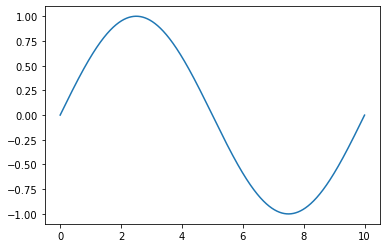

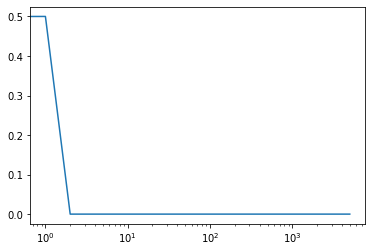

In [2]:
sin = np.sin(2*np.pi*f_signal*t)
plt.plot(t, sin)

print(len(sin))

nfft = sin.size
fft_mod = (1/nfft)*np.abs(scipy.fft.fft(sin)[:nfft//2])
plt.figure()
plt.semilogx(fft_mod)

print(np.max(fft_mod))

APPLY SNR DESIRED TO NOISY_SIGNAL CREATION

In [3]:
SNR = 15; #SNR desired

10000


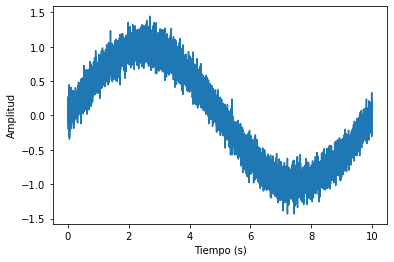

In [3]:
Ps = np.mean(np.power(sin, 2)) # Power of the input signal
Pn = Ps / (np.power(10, (SNR/10))) # Power of the signal with noise
noise = math.sqrt(Pn) * np.random.randn(len(sin)) # Create a random signal with the power calculated before
noisy_signal = sin + noise # Create the input signal with noise

print(len(sin))

plt.plot(t, noisy_signal)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

FLOAT TO FIXED POINT FUNCTION

In [33]:
def to_signed_fixed_point(num, integer_bits, decimal_bits):
    if num < 0:
        sign = 1
        num *= -1
    else:
        sign = 0
    integer_part = int(num)
    decimal_part = num - integer_part
    binary_integer_part = format(integer_part, f'0{integer_bits}b')
    binary_decimal_part = ''
    while decimal_part > 0 and len(binary_decimal_part) < decimal_bits:
        decimal_part *= 2
        if decimal_part >= 1:
            binary_decimal_part += '1'
            decimal_part -= 1
        else:
            binary_decimal_part += '0'
    binary_number = binary_integer_part + binary_decimal_part
    if sign == 1:
        inverted_binary_number = ''
        for bit in binary_number:
            if bit == '1':
                inverted_binary_number += '0'
            elif bit == '0':
                inverted_binary_number += '1'
        binary_number = inverted_binary_number
        binary_number = binary_number[::-1]
        carry = 1
        inverted_twos_complement_binary = ''
        for bit in binary_number:
            if bit == '1' and carry == 1:
                inverted_twos_complement_binary += '0'
            elif bit == '0' and carry == 1:
                inverted_twos_complement_binary += '1'
                carry = 0
            else:
                inverted_twos_complement_binary += bit
        twos_complement_binary = inverted_twos_complement_binary[::-1]
        return twos_complement_binary
    else:
        return binary_number

STORE NOISY_SIGNAL IN TXT

In [15]:
# Store noisy signal with data x line
file = "noisy_signal.txt"
with open(file, "w") as f:
    for i in range(len(noisy_signal)):
        f.write(str(to_signed_fixed_point(noisy_signal[i], 2, 30)))
        #for j in range (3, -1, 1):
            #f.write(str(to_signed_fixed_point(noisy_signal[i], 2, 30)[j*8:8*(j+1)]))
        f.write("\n")

STORE BYTE BY BYTE NOISY_SIGNAL IN TXT

In [45]:
# Store noisy signal with byte data x line

file = "noisy_signal_byte.txt"
with open(file, "w") as f:
    for i in range(len(noisy_signal)):
        for j in range(3, -1, -1):
            # Obtener los siguientes 8 bits del dato actual
            start_bit = j*8
            end_bit = (j+1)*8
            eight_bits = to_signed_fixed_point(noisy_signal[i], 2, 30)[start_bit:end_bit]
            
            # Escribir los 8 bits en una línea separada
            f.write(eight_bits + "\n")

In [66]:
def dividir_lineas(archivo_entrada, archivo_salida):
    with open(archivo_entrada, 'r') as file_in:
        lineas = file_in.readlines()

        with open(archivo_salida, 'w') as file_out:
            for linea in lineas:
                linea = linea.strip()  # Eliminar espacios en blanco y saltos de línea
                sublineas = [linea[i:i+8] for i in range(0, len(linea), 8)]
                sublineas.reverse()
                file_out.write('\n'.join(sublineas) + '\n')

    print("División de líneas completada. El resultado se ha guardado en", archivo_salida)


# Ejemplo de uso
archivo_entrada = 'noisy_signal.txt'  # Reemplaza 'entrada.txt' con la ruta y nombre de tu archivo de entrada
archivo_salida = 'noisy_signal_byte.txt'  # Reemplaza 'salida.txt' con la ruta y nombre deseado para el archivo de salida

dividir_lineas(archivo_entrada, archivo_salida)


División de líneas completada. El resultado se ha guardado en noisy_signal_byte.txt


SEND NOISY_SIGNAL THROUGH UART

In [67]:
import time
import serial
#Enviar senyal directament en binary
send_signal = np.loadtxt('noisy_signal_byte.txt', dtype = 'str')

ser = serial.Serial(port='COM13', baudrate=500000, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=0, rtscts=0)

ser.reset_input_buffer()
ser.reset_output_buffer()

usleep = lambda x: time.sleep(x/1000000.0)

bytes_uart = []
for i in range(len(send_signal)):
    byte_to_int = int(send_signal[i],2)
    #print(send_signal[i])
    #print(byte_to_int)
    ser.write([byte_to_int])
    bytes_uart.append(byte_to_int)

#usleep(10)

READ UART AND STORE DATA TO VECTOR

In [68]:
data = []
while ser.in_waiting > 0:
    data_byte = ser.read()
    data.append(data_byte)
    print(data_byte.hex())

ser.close()

ff
ff
ff
ff
be
95
f8
ff
18
da
df
ff
5d
e4
01
02
1a
0c
52
06
fe
b0
45
0a
28
ff
f3
0c
3b
70
64
10
c3
04
2d
15
7a
ac
b9
17
7e
e1
22
1c
7c
a9
1d
20
8a
89
c9
23
b6
85
86
25
f0
78
c6
28
1c
5e
88
2c
4b
3a
47
30
ad
e0
c2
31
c4
ad
03
34
f1
83
33
36
2d
28
33
39
ea
c5
bb
38
43
ad
32
3b
26
86
85
3d
50
aa
9c
3e
df
0a
5a
3f
1d
01
15
3f
94
50
5b
3f
04
c3
ed
3f
b9
5e
ad
3f
4b
1c
13
3e
a1
52
b2
3c
1a
04
74
3c
7c
17
95
3b
e5
2c
29
3a
e2
ae
9f
38
e3
a7
e6
36
f9
ab
4d
34
8a
d9
00
32
0d
c7
4e
2f
a8
d3
c1
2c
b2
ee
71
29
46
fe
31
26
76
5d
9f
24
6b
5f
46
20
5e
02
2c
1d
a5
7f
9a
18
97
9b
7e
14
46
16
ad
11
9f
83
04
0e
36
39
a5
09
26
79
1d
06
7e
4e
6e
02
7a
ea
77
ff
27
6b
17
fa
5c
48
c4
f6
78
3c
b0
f2
55
8c
a5
ee
79
a8
f6
e9
27
17
62
e6
a7
22
97
e3
2d
24
7a
df
92
f1
a5
dc
ac
6a
6c
da
22
1a
09
d7
13
0b
55
d3
23
44
1e
d0
ad
bd
5a
cd
a9
37
5a
cc
11
ab
cf
c9
8a
e3
88
c8
eb
1b
ac
c5
91
e9
88
c4
be
71
a7
c3
63
b6
14
c3
55
e1
77
c2
e0
55
25
c1
e5
ed
ec
c0
5e
b0
4d
c1
4f
fe
6d
c1
9d
4c
03
c1
0f
1b
ca
c2
d2
1e
62
c3
ca
2

In [50]:
len(data)

401

WRITE DATA TO TXT

In [69]:
file_path = "output_file_fpga.txt"  # Ruta del archivo de texto de salida

# Abre un nuevo archivo en modo escritura
with open(file_path, "w") as f:
    for i in range (len(data)):
        byte_variable = data[i]
        # Convierte el byte en una cadena de bits
        bits_str = ''.join(format(byte, '08b') for byte in byte_variable)
        #print(bits_str)
        bit_write = bits_str[::-1]
        #print(bit_write)
        f.write(bit_write)
        f.write('\n')

JOIN DATA BYTES INTO 32 BIT DATA TO TXT

In [70]:
def juntar_lineas(archivo_entrada, archivo_salida):
    with open(archivo_entrada, 'r') as archivo_lectura, open(archivo_salida, 'w') as archivo_escritura:
        lineas = archivo_lectura.readlines()
        for i in range(0, len(lineas), 4):
            grupo = lineas[i:i+4]
            lineas_sin_salto = [linea.strip() for linea in grupo]
            linea_unida = ''.join(lineas_sin_salto)
            archivo_escritura.write(linea_unida[::-1] + '\n')

archivo_entrada = 'output_file_fpga.txt'
archivo_salida = 'output_file_fpga_total.txt'
juntar_lineas(archivo_entrada, archivo_salida)

FIXED POINT TO FLOAT FUNCTION

In [21]:
def twos_complement_binary_to_float(binary_num, integer_bits, decimal_bits):
    def binary_addition(bin_num):
        carry = 1
        result = ""
        for bit in reversed(bin_num):
            if bit == "0" and carry == 0:
                result = "0" + result
                carry = 0
            elif bit == "0" and carry == 1:
                result = "1" + result
                carry = 0
            elif bit == "1" and carry == 0:
                result = "1" + result
                carry = 0
            elif bit == "1" and carry == 1:
                result = "0" + result
                carry = 1
        if carry == 1:
            result = "1" + result
        return result
    
    float_number = 0.0
    pos = 1
    negative = False
    
    if binary_num[0] == '1':
        negative = True
        new_binary_num = ''.join('1' if bit == '0' else '0' for bit in binary_num)
        new_binary_num = binary_addition(new_binary_num)
        #print(new_binary_num)
    else:
        new_binary_num = binary_num
    
    for bit in range(integer_bits + decimal_bits):
        if 0 <= bit < integer_bits:
            if new_binary_num[bit] == '1':
                if negative:
                    float_number -= 2 ** (integer_bits - bit - 1)
                else:
                    float_number += 2 ** (integer_bits - bit - 1)
        else:
            if new_binary_num[bit] == '1':
                if negative: 
                    float_number -= (2 ** -pos)
                else:
                    float_number += (2 ** -pos)
            pos += 1
    return float_number

NOISY SIGNAL

In [81]:
file_path = "noisy_signal_real.txt"
input_file = "noisy_signal.txt"

integer_bits = 2
decimal_bits = 30

with open(input_file, 'r') as f1:
    with open(file_path, 'w') as f2:
        for line in f1: #la ultima linea es rara i no es de 32 bits per això dona error
            #rint(line) 
            float_num = twos_complement_binary_to_float(line.rstrip(), integer_bits, decimal_bits)
            f2.write(str(float_num) + '\n')

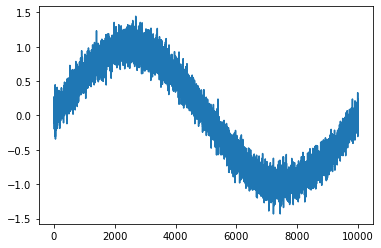

In [4]:
noisy_signal = np.loadtxt("noisy_signal_real.txt")
plt.plot(noisy_signal)

BINARY TEXT TO FLOAT TEXT

In [73]:
file_path = "output_file_fpga_real.txt"
input_file = "output_file_fpga_total.txt"

integer_bits = 2
decimal_bits = 30

with open(input_file, 'r') as f1:
    with open(file_path, 'w') as f2:
        for line in f1: #la ultima linea es rara i no es de 32 bits per això dona error
            #rint(line) 
            float_num = twos_complement_binary_to_float(line.rstrip(), integer_bits, decimal_bits)
            f2.write(str(float_num) + '\n')

IndexError: string index out of range

PLOT FPGA RESULT

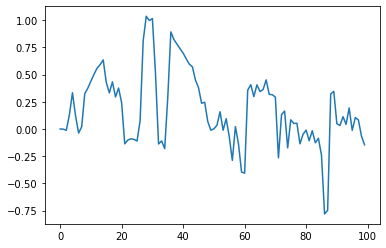

In [59]:
vhdl = np.loadtxt('output_file_fpga_real.txt')
plt.plot(vhdl)
#plt.plot(output_signal[0:9])

In [5]:
# Filter coefficients
b = np.array([-0.000104727467330348859462715860324522055,
-0.000392074744998403314222290561019690358,
-0.000781715557635020508522871729439884803,
-0.00147668595952192647363654387504539045, 
-0.0024103367236310464793991314991217223,  
-0.003620416280096990305215065575339394854,
-0.005004144859511363424564578394893032964,
-0.006424705176368399224540173264585973811,
-0.00764111056876326522058207046939060092, 
-0.008349346880155098654663348156645952258,
-0.008185117603058469915033867891906993464,
-0.006769503914956541586189775472348628682,
-0.003750602374476772523509415790954335534,
 0.001139480059234831890030426038151745161,
 0.008033174150323582271560063361448555952,
 0.016882754688886700972227927763924526516,
 0.027433523680081089990423492963600438088,
 0.039220331323394204414700681127214920707,
 0.051590887374392463415873066878702957183,
 0.063755750725587256866333518701139837503,
 0.074860229325539123790278495107486378402,
 0.084070156970805984264494270519207930192,
 0.090660968225924981611640873779833782464,
 0.094098184868813189440928113072004634887,
 0.094098184868813189440928113072004634887,
 0.090660968225924981611640873779833782464,
 0.084070156970805984264494270519207930192,
 0.074860229325539123790278495107486378402,
 0.063755750725587256866333518701139837503,
 0.051590887374392463415873066878702957183,
 0.039220331323394204414700681127214920707,
 0.027433523680081089990423492963600438088,
 0.016882754688886700972227927763924526516,
 0.008033174150323582271560063361448555952,
 0.001139480059234831890030426038151745161,
-0.003750602374476772523509415790954335534,
-0.006769503914956541586189775472348628682,
-0.008185117603058469915033867891906993464,
-0.008349346880155098654663348156645952258,
-0.00764111056876326522058207046939060092, 
-0.006424705176368399224540173264585973811,
-0.005004144859511363424564578394893032964,
-0.003620416280096990305215065575339394854,
-0.0024103367236310464793991314991217223,  
-0.00147668595952192647363654387504539045,
-0.000781715557635020508522871729439884803,
-0.000392074744998403314222290561019690358,
-0.000104727467330348859462715860324522055])


# Frecuencia de muestreo deseada para la señal de salida
fs_out = 1

# Factor de decimación
q = int(fs_in / fs_out)

# Decimar la señal de entrada
filtered_signal = signal.lfilter(b, 1.0, noisy_signal)
decimated_signal = filtered_signal[::10]
filtered2 = signal.lfilter(b, 1.0, decimated_signal)
output_signal = filtered2[::10]

# SNR signal filtered
P_signal_filtered = np.mean(np.power(filtered_signal, 2))
P_noise_filtered = np.mean(np.power(noisy_signal - filtered_signal, 2))
SNR_filtered_db = 10 * np.log10(P_signal_filtered / P_noise_filtered)
print("SNR filtrada:", SNR_filtered_db)

# SNR signal decimated
P_signal_decimated = np.mean(np.power(decimated_signal, 2))
P_noise_decimated = P_signal_filtered / (np.power(10, (SNR/10)))
SNR_decimated_db = 10 * np.log10(P_signal_decimated / P_noise_decimated)
print("SNR decimada:", SNR_decimated_db)

SNR filtrada: 14.601437057044684
SNR decimada: 14.999966420796875


In [159]:
num = "10011001100010000010111111111111"

print(twos_complement_binary_to_float(num, 2, 30))

01100110011101111101000000000001
-1.6010627755895257


In [170]:
import base64

file_path = "output_file_fpga.txt"  # Ruta del archivo de texto de salida

# Abre un nuevo archivo en modo escritura
with open(file_path, "w") as f:
    # Itera sobre los datos en el array 'data'
    for i in range(0, len(data), 4):
        # Obtiene los siguientes 4 bytes
        bytes_linea = data[i:i+4]
         # Convierte los bytes en cadenas de bits
        # Convierte los bytes en enteros y luego en cadenas de bits
        lineas_bits = [format(int.from_bytes(byte, 'big'), '08b') for byte in bytes_linea]

        # Escribe las cadenas de bits en el archivo
        f.write("".join(lineas_bits))
        f.write('\n')

In [123]:
import base64

file_path = "output_file_fpga.txt"  # Ruta del archivo de texto de salida

# Abre un nuevo archivo en modo escritura
with open(file_path, "w") as f:
    # Itera sobre los datos en el array 'data' en orden inverso
    for i in range(len(data)+4, 1, +4):
        # Obtiene los siguientes 4 bytes en orden inverso
        bytes_linea = data[i-4::i]
        # Convierte los bytes en cadenas de bits y revierte el orden
        lineas_bits = [format(int.from_bytes(byte, 'big'), '08b')for byte in bytes_linea]
        # Escribe las cadenas de bits en el archivo, cada dato al principio de la línea
        f.write("".join(lineas_bits[::-1]))
        f.write('\n')

In [160]:
num = "100"

print(num[0])

1


In [31]:
def invertir_lineas(archivo_entrada, archivo_salida):
    # Leer el archivo de entrada
    with open(archivo_entrada, 'r') as f_entrada:
        # Leer todas las líneas del archivo
        lineas = f_entrada.readlines()

    # Abrir el archivo de salida en modo escritura
    with open(archivo_salida, 'w') as f_salida:
        # Iterar sobre las líneas
        for linea in lineas:
            # Invertir la línea
            linea_invertida = linea.strip()[::-1]

            # Escribir la línea invertida en el archivo de salida
            f_salida.write(linea_invertida)
            f_salida.write('\n')

    print(f"Se han invertido las líneas del archivo '{archivo_entrada}' y se han guardado en '{archivo_salida}'.")

archivo_entrada = 'noisy_signal_byte.txt'#'output_file_fpga.txt'
archivo_salida = 'noisy_signal_byte_inv.txt'#'output_file_fpga_total.txt'
invertir_lineas(archivo_entrada, archivo_salida)

Se han invertido las líneas del archivo 'noisy_signal_byte.txt' y se han guardado en 'noisy_signal_byte_inv.txt'.


In [161]:
archivo_entrada = 'output_file_fpga_total.txt'
archivo_salida = 'output_file_fpga_total_inv.txt'


Se han juntado los bytes del archivo 'output_file_fpga_total.txt' y se han guardado en 'output_file_fpga_total_inv.txt'.


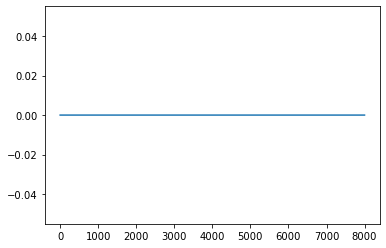

In [98]:
noisy_signal_int = []
out = np.loadtxt('output_file_fpga.txt')
out_int = []
for i in range (len(noisy_signal)):
    noisy_signal_int.append(int(noisy_signal[i]))
    
    
for i in range (len(out)):
    out_int.append(int(out[i]))
    
#plt.plot(noisy_signal_int)
#plt.plot(out_int)

import numpy as np

# Ajustar el tamaño de los vectores para que tengan la misma longitud
min_length = min(len(noisy_signal_int), len(out_int))
vector1 = np.array(noisy_signal_int)
vector2 = np.array(out_int)
# Restar los vectores
rest = vector1 - vector2

plt.plot(rest)

In [163]:
def invertir_lineas(archivo_entrada, archivo_salida):
    # Abrir el archivo de entrada en modo lectura
    with open(archivo_entrada, 'r') as f_entrada:
        # Leer todas las líneas del archivo
        lineas = f_entrada.readlines()

    # Abrir el archivo de salida en modo escritura
    with open(archivo_salida, 'w') as f_salida:
        # Recorrer cada línea y escribir su versión invertida en el archivo de salida
        for linea in lineas:
            linea_invertida = linea[::-1]  # Invertir la línea
            f_salida.write(linea_invertida)

    print(f'Se ha invertido el contenido de "{archivo_entrada}" y se ha guardado en "{archivo_salida}".')

# Ejemplo de uso
archivo_entrada = 'output_file_fpga_total.txt'
archivo_salida = 'output_file_fpga_total_inv.txt'
invertir_lineas(archivo_entrada, archivo_salida)

Se ha invertido el contenido de "output_file_fpga_total.txt" y se ha guardado en "output_file_fpga_total_inv.txt".


In [157]:
bin_num = "1101"
float_num = twos_complement_binary_to_float(bin_num, 2, 2)
print(float_num)

0011
-0.75


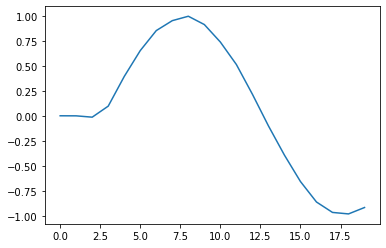

In [4]:
vhdl_real = np.loadtxt('output_file_real_sim.txt')
plt.plot(vhdl_real)

0.0


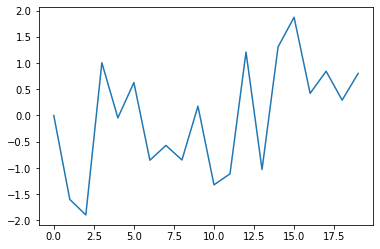

In [158]:
fpga_real = np.loadtxt('output_file_fpga_real.txt')
print(fpga_real[0])
plt.plot(fpga_real)

In [3]:
file_path = "output_file_real_sim.txt"  # Ruta del archivo de texto de salida
input_file_path = "output_file.txt"  # Ruta del archivo de texto de entrada
integer_bits = 2  # Número de bits para la parte entera
decimal_bits = 30  # Número de bits para la parte decimal

with open(input_file_path, 'r') as input_file:
    with open(file_path, 'w') as output_file:
        for line in input_file:
            float_num = twos_complement_binary_to_float(line, integer_bits, decimal_bits)
            output_file.write(str(float_num) + '\n')

000000000000101000011101110110001
000000001110001101111000110001001
000001100111000110010010001000111
000110010011000011011011111101111
001010100001100000110000111110111
001101110011010101000100000100111
001111011110001000111011011001101
001111101101011010010010111001101
001110101011110001000100001010001


In [ ]:
file = "output_file.txt"
with open(file, "r") as f:
    vhdl = [int(line.strip(), 2) for line in f if line.strip()]

file = "output_file_real.txt"
with open(file, "w") as f:
    for num in vhdl:
        #binary_num = bin(num)[2:].zfill(30)
        #binary_num = bin(num)
        print(binary_num)
        #f.write(str(twos_complement_binary_to_float(binary_num, 2, 30)))
        #f.write("\n")
        
vhdl_real = np.loadtxt('output_file_real.txt')
        
plt.plot(vhdl_real, 'r')

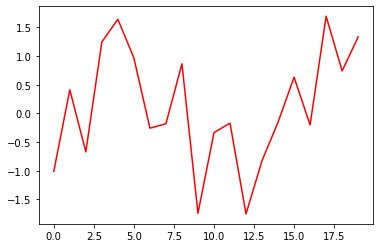

In [46]:
sinus = np.loadtxt('output_file_fpga_real.txt')
plt.plot(sinus, 'r')

Text(0.5, 1.0, 'Hardware output and hardware simulation difference')

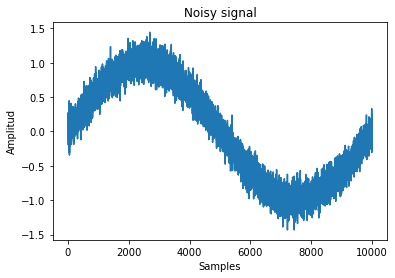

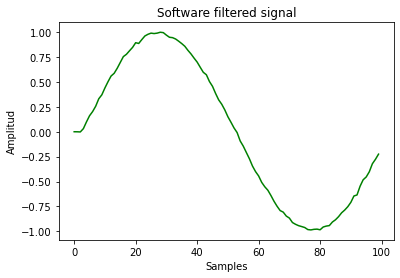

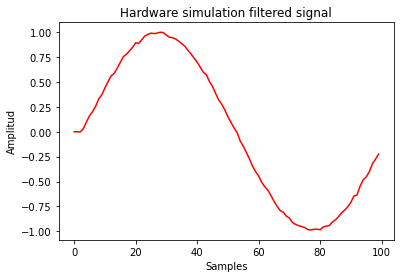

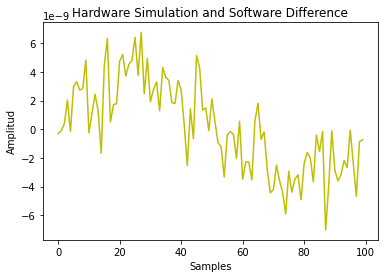

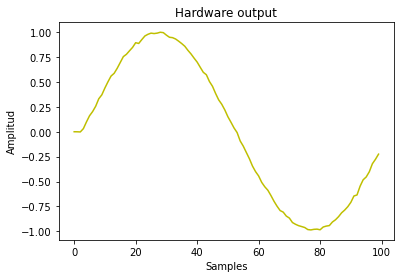

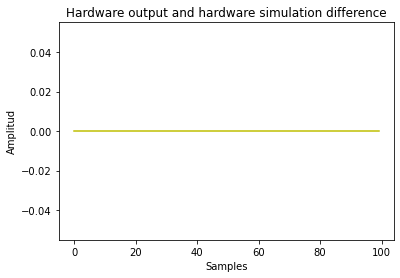

In [6]:
fpga = np.loadtxt('output_file_fpga_real.txt')
sim = np.loadtxt('output_file_real_vhdl_sim.txt')
dif = sim - output_signal
dif2 = sim - fpga


# Graficar señal de entrada y salida
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()

ax1.plot(noisy_signal)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Amplitud')
ax1.set_title('Noisy signal')

ax2.plot(output_signal, 'g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Amplitud')
ax2.set_title('Software filtered signal')

ax3.plot(sim, 'r')
ax3.set_xlabel('Samples')
ax3.set_ylabel('Amplitud')
ax3.set_title('Hardware simulation filtered signal')

ax4.plot(dif, 'y')
ax4.set_xlabel('Samples')
ax4.set_ylabel('Amplitud')
ax4.set_title('Hardware Simulation and Software Difference')

ax5.plot(fpga, 'y')
ax5.set_xlabel('Samples')
ax5.set_ylabel('Amplitud')
ax5.set_title('Hardware output')

ax6.plot(dif2, 'y')
ax6.set_xlabel('Samples')
ax6.set_ylabel('Amplitud')
ax6.set_title('Hardware output and hardware simulation difference')

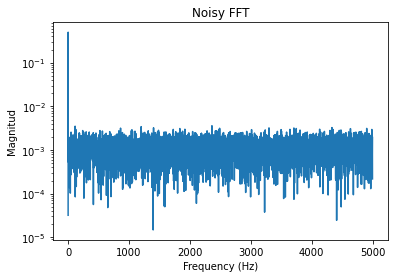

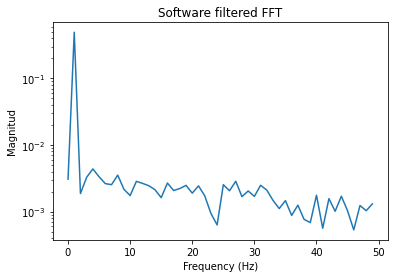

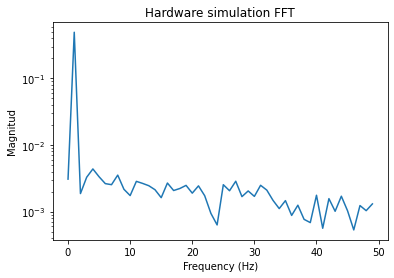

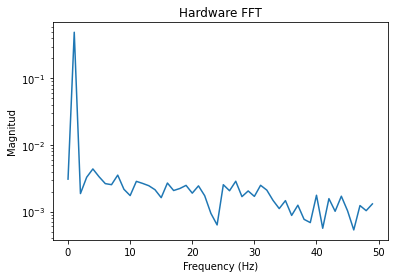

In [10]:
# Calcular la transformada de Fourier de la señal
nfft_noisy = noisy_signal.size
fft_mod_noisy = (1/nfft_noisy)*np.abs(scipy.fft.fft(noisy_signal)[:nfft_noisy//2])

nfft_output = output_signal.size
fft_mod_output = (1/nfft_output)*np.abs(scipy.fft.fft(output_signal)[:nfft_output//2])

nfft_sim = sim.size
fft_mod_sim = (1/nfft_sim)*np.abs(scipy.fft.fft(sim)[:nfft_sim//2])

nfft_fpga = fpga.size
fft_mod_fpga = (1/nfft_fpga)*np.abs(scipy.fft.fft(fpga)[:nfft_fpga//2])

#NOISY_FFT = np.fft.fft(noisy_signal)
#FILTERED_FFT = np.fft.fft(filtered_signal)
#DECIMATED_FFT = np.fft.fft(decimated_signal)
#FILTERED2_FFT = np.fft.fft(filtered2)
#OUTPUT_SIGNAL_FFT = np.fft.fft(output_signal)

# Crear los ejes de frecuencia para la visualización
freqs = np.fft.fftfreq(len(t), Ts)
freqs_2 = np.fft.fftfreq(len(output_signal), Ts*10*10)

# Graficar señal de entrada y salida
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

ax1.plot(fft_mod_noisy)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitud')
ax1.set_title('Noisy FFT')
ax1.set_yscale('log')
#ax1.set_xlim([0, 100])
#ax1.set_yscale('log')

ax2.plot(fft_mod_output)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitud')
ax2.set_title('Software filtered FFT')
#ax2.set_xlim([0, 100])
ax2.set_yscale('log')

ax3.plot(fft_mod_sim)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitud')
ax3.set_title('Hardware simulation FFT')
ax3.set_yscale('log')
#ax3.set_xlim(0, 100)

ax4.plot(fft_mod_fpga)
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitud')
ax4.set_title('Hardware FFT')
ax4.set_yscale('log')
#ax4.set_xlim(0, 100)

In [ ]:
# Calcular la FFT de la señal ruidosa
fft = np.fft.fft(noisy_signal)
freqs = np.fft.fftfreq(len(t), 1/fs_in)

# Normalizar y escalar la FFT
fft_norm = np.abs(fft) / len(fft) * 2  # Normalización y escala
amplitude = np.max(fft_norm)  # Amplitud máxima de la FFT
fft_norm = fft_norm / amplitude  # Escala para que la amplitud máxima sea 1

# Graficar la FFT normalizada y escalada
plt.plot(freqs, fft_norm)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud normalizada')
plt.title('FFT de señal ruidosa normalizada y escalada')
plt.show()